# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import optuna
from optuna.samplers import TPESampler
import warnings
import shap
warnings.filterwarnings("ignore")

# Read data
#### This dataset was collected as part of a comprehensive survey aimed at understanding the factors contributing to depression risk among adults.
#### Feature Descriptions
1. Name: paticipant's name.

2. Gender: paticipant's gender (Male/Female).

3. Age: paticipant's age (18-60).

4. City: paticipant's city.

5. Working Professional or Student: whether the participant is a working professional or a student

6. Profession: participant's current profession 

7. Academic Pressure: academic workload level on a scale from 1 to 5

8. Work Pressure: work workload level on a scale from 1 to 5

9. CGPA: cumulative grade point average

10. Study Satisfaction: participant's satisfaction level with their studies on a scale from 1 to 5

11. Job Satisfaction: participant's satisfaction level with their job on a scale from 1 to 5

12. Sleep Duration: the average duration of sleep 

13. Dietary Habits: information about the participant's eating habits

14. Degree: the highest degree or qualification obtained by the participant

15. Have you ever had suicidal thoughts ?: Yes or No

16. Work/Study Hours: average hours spent working or/and studying daily

17. Financial Stress: the level of financial stress experienced on a scale from 1 to 5

18. Family History of Mental Illness: Yes or No

19. Depression: represents whether the participant is at risk of depression (Yes or No), based on their responses to lifestyle and demographic factors.

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e11/train.csv', index_col='id')
train.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [3]:
test = pd.read_csv('/kaggle/input/playground-series-s4e11/test.csv', index_col='id')
test.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
id,,,,,,,,,,,,,,,,,,
140700,Shivam,Male,53.0,Visakhapatnam,Working Professional,Judge,NaN,2.0,NaN,NaN,5.0,Less than 5 hours,Moderate,LLB,No,9.0,3.0,Yes
140701,Sanya,Female,58.0,Kolkata,Working Professional,Educational Consultant,NaN,2.0,NaN,NaN,4.0,Less than 5 hours,Moderate,B.Ed,No,6.0,4.0,No
140702,Yash,Male,53.0,Jaipur,Working Professional,Teacher,NaN,4.0,NaN,NaN,1.0,7-8 hours,Moderate,B.Arch,Yes,12.0,4.0,No
140703,Nalini,Female,23.0,Rajkot,Student,NaN,5.0,NaN,6.84,1.0,NaN,More than 8 hours,Moderate,BSc,Yes,10.0,4.0,No
140704,Shaurya,Male,47.0,Kalyan,Working Professional,Teacher,NaN,5.0,NaN,NaN,5.0,7-8 hours,Moderate,BCA,Yes,3.0,4.0,No


# EDA + preprocessing

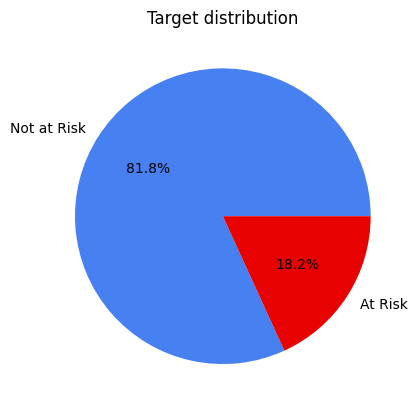

In [4]:
colors = ['#4780f0', '#e70101']
plt.pie(train.Depression.value_counts(), labels=['Not at Risk', 'At Risk'], autopct="%.1f%%", colors=colors)
plt.title('Target distribution')
plt.show()

Since classes are imbalanced, accuracy is not the best way to evaluate the model performance. We can get 82% accuracy just by constantly predicting 0 on all samples.



#### Preprocessing:

In [5]:
train = train.fillna('None').astype('string')
test = test.fillna('None').astype('string')

y = train['Depression']
X = train.drop(['Depression'], axis=1)

# Model

I'll be using ROC-AUC and Accuracy to assess the model, actually focusing on ROC-AUC during training.

In [6]:
catboost_params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': 0.08114394459649094,
    'iterations': 1000,
    'depth': 6,
    'random_strength':0,
    'l2_leaf_reg': 0.7047064221215757,
    'task_type':'GPU',
    'random_seed':42,
    'verbose':False    
}

In [7]:
cv = StratifiedKFold(5, shuffle=True, random_state=0)
cv_splits = cv.split(X, y)
scores = []
test_preds = []
X_test_pool = Pool(test, cat_features=X.columns.values)
for i, (train_idx, val_idx) in enumerate(cv_splits):
    model = CatBoostClassifier(**catboost_params)
    X_train_fold, X_val_fold = X.loc[train_idx], X.loc[val_idx]
    y_train_fold, y_val_fold = y.loc[train_idx], y.loc[val_idx]
    X_train_pool = Pool(X_train_fold, y_train_fold, cat_features=X.columns.values)
    X_valid_pool = Pool(X_val_fold, y_val_fold, cat_features=X.columns.values)
    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=False, early_stopping_rounds=200)
    val_pred = model.predict(X_valid_pool)
    score = accuracy_score(y_val_fold, val_pred)
    scores.append(score)
    test_pred = model.predict_proba(X_test_pool)[:, 1]
    test_preds.append(test_pred)
    print(f'Fold {i + 1} accuracy_score: {score}')
print(f'Cross-validated accuracy_score: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
print(f'Max accuracy_score score: {np.max(scores):.3f}')
print(f'Min accuracy_score score: {np.min(scores):.3f}')

Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 accuracy_score: 0.9404761904761905


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 accuracy_score: 0.9383084577114428


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 3 accuracy_score: 0.940547263681592


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 4 accuracy_score: 0.9403340440653873


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 5 accuracy_score: 0.9388770433546553
Cross-validated accuracy_score: 0.940 +/- 0.001
Max accuracy_score score: 0.941
Min accuracy_score score: 0.938


# Submission

In [8]:
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e11/sample_submission.csv')
sample_submission['Depression'] = np.round(np.mean(test_preds, axis=0))
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,id,Depression
0,140700,0.0
1,140701,0.0
2,140702,0.0
3,140703,1.0
4,140704,0.0
5,140705,0.0
6,140706,0.0
7,140707,0.0
8,140708,0.0
9,140709,1.0
